## Project 1: American Sign Language Understanding
A project for the course of Autonomous Learning at the University of Aveiro, 2022/2023. This project was developed by Diogo Monteiro (NMec 97606) and Isabel Rosário (NMec 93343). This approach attemps to build a neural network that understands American sign language.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

Number of images in dataset: 27455
Shape of each image: (28, 28)


Text(0.5, 1.0, 'First image of the dataset')

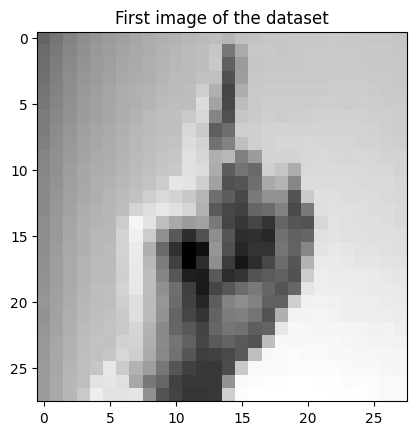

In [2]:
data = pd.read_csv('data/sign_mnist_train.csv')

# get number of images in the dataset (should be 27,455)
num_images = data.shape[0]
print('Number of images in dataset:', num_images)

# single out and analyse first image
first_image = data.iloc[0, 1:].values # get first image of the dataset
first_image = first_image.reshape(28, 28).astype('uint8') # reshape it to a 28x28 matrix
print('Shape of each image:', first_image.shape)

# show first image
plt.imshow(first_image, cmap='gray')
plt.title('First image of the dataset')

In [3]:
# normalize pixel information (0-255 to 0-1)
data.iloc[:, 1:] = data.iloc[:, 1:] / 255
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

### Neural network code

In [6]:
class Layer:

    def __init__(self, numInputs, numNeurons):
        # random initialization of weights
        self.weights = 0.01 * np.random.randn(numInputs, numNeurons) # 0.01 to avoid exploding gradients
        self.biases = np.zeros((1, numNeurons)) # biases are initialized to 0
    
    def forwardPass(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases # Z = XW + B

    def backPropagation(self, lossDerivatives): # lossPartialDerivates = partial derivatives of loss function with respect to output of layer
        # compute gradients (partial derivatives)
        self.weightDerivatives = np.dot(self.inputs.T, lossDerivatives) # dL/dW = dL/dY * dY/dW
        self.biasDerivatives = np.sum(lossDerivatives, axis=0, keepdims=True) # dL/dB = dL/dY * dY/dB
        self.inputDerivatives = np.dot(lossDerivatives, self.weights.T) # dL/dX = dL/dY * dY/dX

class Activation:
    # activation functions: they are applied to the output of a layer in order to introduce non-linearity

    def forwardPassReLU(self, inputs): # rectified linear unit
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backPropagationReLU(self, lossDerivatives): # derivative of ReLU
        self.inputDerivatives = lossDerivatives.copy()
        self.inputDerivatives[self.inputs <= 0] = 0

    def forwardPassSoftmax(self, inputs): # softmax activation: softmax(x) = exp(x) / sum(exp(x))
        exponentials = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exponentials / np.sum(exponentials, axis=1, keepdims=True)
        self.output = probabilities

    def backPropagationSoftmax(self, lossDerivatives): # derivative of softmax
        self.inputDerivatives = np.empty_like(lossDerivatives)
        for index, (singleOutput, singleLossDerivatives) in enumerate(zip(self.output, lossDerivatives)): # iterate over samples
            singleOutput = singleOutput.reshape(-1, 1) # reshape to column vector
            jacobian = np.diagflat(singleOutput) - np.dot(singleOutput, singleOutput.T) # compute jacobian matrix
            self.inputDerivatives[index] = np.dot(jacobian, singleLossDerivatives) # compute partial derivatives

class Loss:
    # categorical cross-entropy: it is used to evaluate the performance of a classification model by comparing the predicted output to the true output
    # it is a kind of loss function: it measures how well the model is performing

    def calculate(self, output, y): # compute loss
        sampleLosses = self.forwardPass(output, y) # compute loss values for each sample
        dataLoss = np.mean(sampleLosses) # compute mean loss
        return dataLoss

    def forwardPass(self, yPred, yTrue):
        samples = len(yPred) # number of samples in a batch
        yPredClipped = np.clip(yPred, 1e-7, 1 - 1e-7) # clip data to prevent division by 0
        if len(yTrue.shape) == 1: # if labels are one-hot encoded
            correctConfidences = yPredClipped[range(samples), yTrue] # get the confidence of the correct label
        elif len(yTrue.shape) == 2: # if labels are integers
            correctConfidences = np.sum(yPredClipped * yTrue, axis=1) # get the confidence of the correct label
        negativeLogLikelihoods = -np.log(correctConfidences) # compute negative log likelihood
        return negativeLogLikelihoods # return loss
    
    def backPropagation(self, lossDerivatives, yTrue):
        samples = len(lossDerivatives) # number of samples
        labels = len(lossDerivatives[0]) # number of labels
        if len(yTrue.shape) == 1: # if labels are one-hot encoded
            yTrue = np.eye(labels)[yTrue] # convert to integer labels
        self.inputDerivatives = -yTrue / lossDerivatives # compute gradient
        self.inputDerivatives = self.inputDerivatives / samples # normalize gradient

class LossActivation:
    # combined softmax activation and cross-entropy loss for faster backward step
    # this is used for the last layer of the model only
    # this makes the backward step faster because it is computed in a single step

    def __init__(self):
        self.activation = Activation()
        self.loss = Loss()

    def forwardPass(self, inputs, y_true):
        self.activation.forwardPassSoftmax(inputs) # apply softmax activation
        self.output = self.activation.output # store output of activation function
        return self.loss.calculate(self.output, y_true) # return loss value

    def backPropagation(self, lossDerivatives, yTrue):
        samples = len(lossDerivatives) # number of samples
        if len(yTrue.shape) == 2:
            yTrue = np.argmax(yTrue, axis=1) # convert one-hot encoded labels to integers
            # one-hot enconded labels mean are labels represented as a vector with a 1 in the position of the label and 0s in the other positions
        self.inputDerivatives = lossDerivatives.copy() # copy gradient values
        self.inputDerivatives[range(samples), yTrue] -= 1 # subtract 1 from the gradient of the correct label
        self.inputDerivatives = self.inputDerivatives / samples # divide by the number of samples

class Optimizer:
    # stochastic gradient descent: it is used to update the weights of the model in order to minimize the loss function
    # it is an optimization algorithm that is used to find the optimal set of weights for the model
    # stochastic gradient descent works by updating the weights incrementally for each training sample
    
    def __init__(self, learningRate=1., decay=0., momentum=0.):
        self.learningRate = learningRate # learning rate: it is a hyperparameter that controls how much to update the weights at the end of each batch
        self.currentLearningRate = learningRate # current learning rate: it is used to update the learning rate over time
        self.decay = decay # decay: it is a hyperparameter that controls how much the learning rate decreases over time
        self.iter = 0 # iterations: it is used to keep track of the number of iterations performed
        self.momentum = momentum # momentum: it is a hyperparameter that controls how much to take the previous updates into account when performing the current update
    
    def beforeParameterUpdate(self):
        if self.decay: # if decay is bigger than zero
            self.currentLearningRate = self.learningRate * (1. / (1. + self.decay * self.iter)) # update the learning rate
    
    def updateParameters(self, layer):
        if self.momentum: # if momentum is bigger than zero
            if not hasattr(layer, 'weightMomentums'): # if the layer does not have weightMomentums attribute
                layer.weightMomentums = np.zeros_like(layer.weights) # initialize weightMomentums with zeros
                layer.biasMomentums = np.zeros_like(layer.biases) # initialize biasMomentums with zeros
            weightUpdates = self.momentum * layer.weightMomentums - self.currentLearningRate * layer.weightDerivatives # compute weight updates
            layer.weightMomentums = weightUpdates # store weight updates
            biasUpdates = self.momentum * layer.biasMomentums - self.currentLearningRate * layer.biasDerivatives # compute bias updates
            layer.biasMomentums = biasUpdates # store bias updates
        else:
            weightUpdates = -self.currentLearningRate * layer.weightDerivatives # compute weight updates
            biasUpdates = -self.currentLearningRate * layer.biasDerivatives # compute bias updates
        layer.weights += weightUpdates # update weights
        layer.biases += biasUpdates # update biases

    def afterParameterUpdate(self):
        self.iter += 1 # increment iterations

### Training

In [8]:
num_features = X.shape[1]
size_layer1 = 256
size_layer2 = 26

activation = Activation()
layer1 = Layer(num_features, size_layer1)
layer2 = Layer(size_layer1, size_layer2)
loss_activation = LossActivation()
optimizer = Optimizer(learningRate=0.05, decay=5e-7)

for epoch in range(10001):
    layer1.forwardPass(X)
    activation.forwardPassReLU(layer1.output)

    layer2.forwardPass(layer1.output)
    loss = loss_activation.forwardPass(layer2.output, y)

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' + f'lr: {optimizer.currentLearningRate}')
    
    # backward pass
    loss_activation.backPropagation(loss_activation.output, y)
    layer2.backPropagation(loss_activation.inputDerivatives)
    activation.backPropagationReLU(layer2.inputDerivatives)
    layer1.backPropagation(layer2.inputDerivatives)

    # update weights and biases
    optimizer.beforeParameterUpdate()
    optimizer.updateParameters(layer1)
    optimizer.updateParameters(layer2)
    optimizer.afterParameterUpdate()



epoch: 0, acc: 0.049, loss: 3.258, lr: 0.05
epoch: 100, acc: 0.140, loss: 3.126, lr: 0.04999752512250644
epoch: 200, acc: 0.205, loss: 2.935, lr: 0.04999502549496326
epoch: 300, acc: 0.310, loss: 2.597, lr: 0.049992526117345455
epoch: 400, acc: 0.370, loss: 2.273, lr: 0.04999002698961558
epoch: 500, acc: 0.445, loss: 2.019, lr: 0.049987528111736124
epoch: 600, acc: 0.500, loss: 1.824, lr: 0.049985029483669646
epoch: 700, acc: 0.541, loss: 1.666, lr: 0.049982531105378675
epoch: 800, acc: 0.573, loss: 1.535, lr: 0.04998003297682575
epoch: 900, acc: 0.560, loss: 1.485, lr: 0.049977535097973466
epoch: 1000, acc: 0.605, loss: 1.365, lr: 0.049975037468784345
epoch: 1100, acc: 0.627, loss: 1.297, lr: 0.049972540089220974
epoch: 1200, acc: 0.650, loss: 1.209, lr: 0.04997004295924593
epoch: 1300, acc: 0.667, loss: 1.141, lr: 0.04996754607882181
epoch: 1400, acc: 0.683, loss: 1.085, lr: 0.049965049447911185
epoch: 1500, acc: 0.685, loss: 1.068, lr: 0.04996255306647668
epoch: 1600, acc: 0.690, lo

In [12]:
# save resulting weights and biases to file
np.savez('model.npz', w1=layer1.weights, b1=layer1.biases, w2=layer2.weights, b2=layer2.biases)

### Testing

In [11]:
# read model from file
model = np.load('model.npz')
w1, b1, w2, b2 = model['w1'], model['b1'], model['w2'], model['b2']

# load test data
test = pd.read_csv('data/sign_mnist_test.csv')
test.iloc[:, 1:] = test.iloc[:, 1:] / 255
X_test, y_test = test.iloc[:, 1:].values, test.iloc[:, 0].values

# make predictions for test data
layer1.forwardPass(X_test)
activation.forwardPassReLU(layer1.output)
layer2.forwardPass(layer1.output)
predictions = np.argmax(layer2.output, axis=1)

# calculate accuracy
accuracy = np.mean(predictions == y_test)
print(f'accuracy: {accuracy:.3f}')


accuracy: 0.701
